In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from sklearn.decomposition import PCA


import gym_env
import utils
from utils import create_mapping, get_transition_matrix, create_mapping_nb, get_full_maze_values

In [2]:
seed = 42
# Set the random seed for NumPy
np.random.seed(42)

## Linear RL Model

In [3]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, beta=1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random", imp_samp=True, diff_type="Max"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_locs = self.env.unwrapped.target_locs
        self.maze = self.env.unwrapped.maze
        self.walls = self.env.unwrapped.get_walls()
        self.size = self.maze.size - len(self.walls)   # Size of the state space is the = size of maze - number of blocked states
        self.height, self.width = self.maze.shape

        # Create mapping and Transition matrix
        self.mapping = create_mapping_nb(self.maze, self.walls)
        self.reverse_mapping = {index: (i, j) for (i, j), index in self.mapping.items()}
        self.T = get_transition_matrix(self.env, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # Set reward
        self.reward_nt = -1
        self.reward_t = -1
        self.r = np.full(len(self.T), self.reward_nt)
        self.r[self.terminals] = self.reward_t
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)
        # Precalculate exp(r) for use with LinearRL equations
        self.expr_nt = np.exp(self.reward_nt / _lambda)

        # Params
        self.alpha = alpha
        self.beta = beta
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy
        self.imp_samp = imp_samp
        self.diff_type = diff_type

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_states(self):
        """
        Returns all non-blocked states as well as a mapping of each state (i,j) -> to an index (k)
        """
        states = []
        index_mapping = {}
        index = 0
        for i in range(len(self.maze)):
            for j in range(len(self.maze[i])):
                if self.maze[i][j] in ['0', 'S', 'G']:
                    states.append((i, j))
                    index_mapping[(i, j)] = index
                    index += 1

        return states, index_mapping

    def get_DR(self):
        """
        Returns the DR initialization based on what decision policy we are using, values are filled with 0.01 if using softmax to avoid div by zero
        """
        if self.policy == "random":
            DR = np.eye(self.size)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            np.fill_diagonal(DR, 1)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(1-self.gamma))

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = self.expr_t
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        """
        Performs importance sampling P(x'|x)/u(x'|x). P(.) is the default policy, u(.) us the decision policy
        """
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=0.5, target_loc=None):
        """
        Action selection based on our policy
        Options are: [random, softmax, egreedy, test]
        """
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / self.beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / self.beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
    
        elif self.policy == "egreedy":
            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        """
        Calculates the DR directly using matrix inversion, used for testing
        """
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent explores the maze according to its decision policy and and updates its DR as it goes
        """
        print(f"Decision Policy: {self.policy}, Number of Iterations: {self.num_steps}, lr={self.alpha}, temperature={self.beta}")
        self.env.reset(seed=seed, options={})
        
        D_inv_1 = self.get_D_inv()
        D_inv_2 = np.linalg.inv(np.diag(np.exp(-self.r))-self.T)
        diff_1, diff_2 = list(), list()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Every 10 steps check difference
            if (i + 1) % 10 == 0:
                if self.diff_type == "Max":
                    diff_1.append(np.max(np.abs((self.gamma * D_inv_1) - (self.gamma * self.DR))))
                    # diff_1.append(np.max(np.abs(D_inv_1 - self.DR)))
                    diff_2.append(np.max(np.abs(D_inv_2 - (self.gamma * self.DR))))
                elif self.diff_type == "Mean":
                    diff_1.append(np.mean(np.abs((self.gamma*D_inv_1) - (self.gamma*self.DR))))
                    diff_2.append(np.mean(np.abs(D_inv_2 - (self.gamma * self.DR))))
                elif self.diff_type == "Median":
                    diff_1.append(np.median(np.abs((self.gamma*D_inv_1) - (self.gamma*self.DR))))
                    diff_2.append(np.median(np.abs(D_inv_2 - (self.gamma * self.DR))))
                    
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state)
            else:
                action = self.select_action(state, self.policy)
        
            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax" and self.imp_samp:
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            target = self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * target * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            if done:
                self.env.reset(seed=seed, options={})
                continue
            
            # Update state
            state = next_state

        # Update DR at terminal state
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

        return [diff_1, diff_2]

### Render Maze

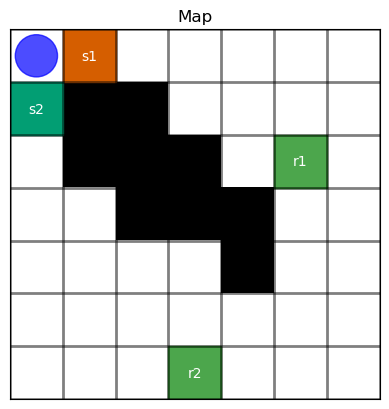

In [4]:
agent = LinearRL(env_name="simple-7x7-2", _lambda=1.0, alpha=0.001, beta=1.0, num_steps=500000, policy="softmax")
utils.render_maze(agent, state=agent.start_loc)

In [5]:
for target_loc in agent.target_locs:
    print(target_loc)

[2 5]
[6 3]


## Test Different Temperature Values and Num Steps

Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.1
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.1
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.4
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.4
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.8
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=0.8
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=1.0
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=1.0
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=1.2
Decision Policy: softmax, Number of Iterations: 20000, lr=0.001, temperature=1.2
Decision Policy: random, Number of Iterations: 20000, lr=0.001, temperature=1


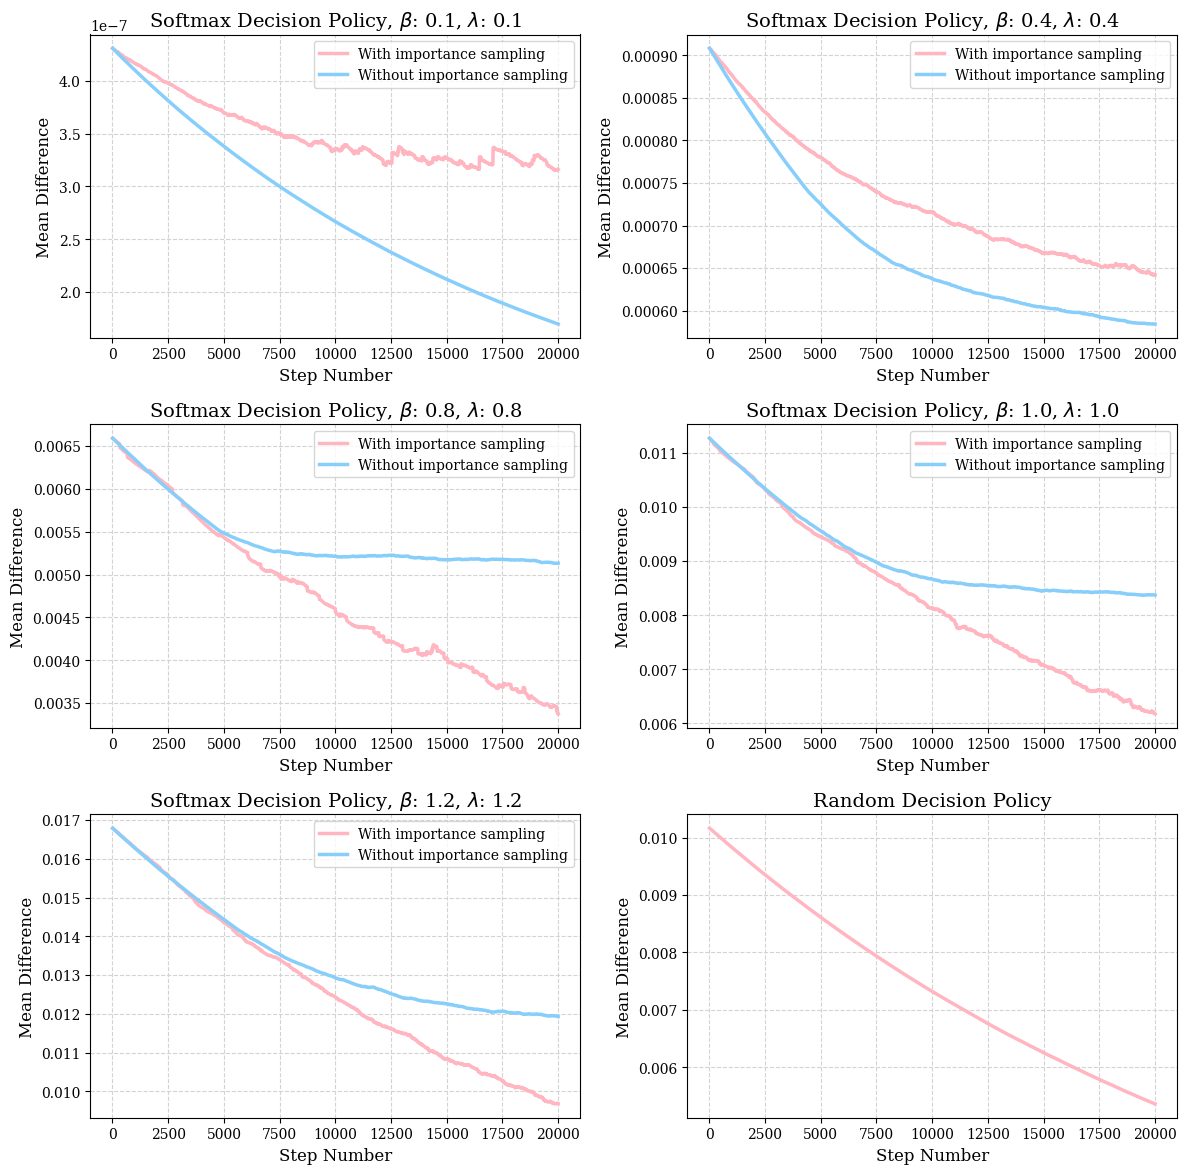

In [21]:
temperature_values = [0.1, 0.4, 0.8, 1.0, 1.2]
envs = ["simple-5x5", "tolman-9x9-nb"]
env_name = envs[0]
diff_types = ["Max", "Mean", "Median"]
diff_type = diff_types[1]
num_steps = 20000

# Set a nicer font
plt.rcParams['font.family'] = 'serif'

# Define pastel colors
colors = ['#FFB6C1', '#FFD700', '#98FB98', '#87CEFA', '#FFA07A']

# Softmax agents
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, temp in enumerate(temperature_values):
    ax = axes[i // 2, i % 2]
    # Define the agent
    agent = LinearRL(env_name=env_name, _lambda=temp, alpha=0.001, beta=temp, num_steps=num_steps, policy="softmax", imp_samp=True, diff_type=diff_type)
    agent_no_imp = LinearRL(env_name=env_name, _lambda=temp, alpha=0.001, beta=temp, num_steps=num_steps, policy="softmax", imp_samp=False, diff_type=diff_type)
    # Get the diffs and set the x-axis
    diffs = agent.learn()
    diffs_no_imp = agent_no_imp.learn()
    x = np.arange(10, num_steps+1, 10)
    # Plot the diffs
    ax.plot(x, diffs[0], label='With importance sampling', color=colors[0], linewidth=2.5)
    ax.plot(x, diffs_no_imp[0], label='Without importance sampling', color=colors[3], linewidth=2.5)
    # ax.plot(x, diffs[1], label='Diff 2', color=colors[3], linewidth=2.2)
    
    # Add labels to the x-axis and y-axis
    ax.set_xlabel('Step Number', fontsize=12)
    ax.set_ylabel(f'{diff_type} Difference', fontsize=12)
    
    # Add a title to the plot
    # ax.set_title(fr'Softmax Decision Policy, $\beta$: {temp}', fontsize=14)
    ax.set_title(fr'Softmax Decision Policy, $\beta$: {temp}, $\lambda$: {temp}', fontsize=14)
    
    # Add a legend to the plot
    ax.legend()
    
    # Add dashed light grey grid lines
    ax.grid(color='lightgrey', linestyle='--')

# Random Agent
ax = axes[2, 1]
agent = LinearRL(env_name=env_name, _lambda=1.0, alpha=0.001, num_steps=num_steps, policy="random", diff_type=diff_type)
diffs = agent.learn()
x = np.arange(10, num_steps+1, 10)

# Plot the diffs
ax.plot(x, diffs[0], color=colors[0], linewidth=2.5)
# ax.plot(x, diffs[1], label='Diff 2', color=colors[3], linewidth=2.4)

# Add labels to the x-axis and y-axis
ax.set_xlabel('Step Number', fontsize=12)
ax.set_ylabel(f'{diff_type} Difference', fontsize=12)

# Add a title to the plot
ax.set_title(f'Random Decision Policy', fontsize=14)

# Add a legend to the plot
# ax.legend()

# Add dashed light grey grid lines
ax.grid(color='lightgrey', linestyle='--')

plt.tight_layout()
plt.show()

In [41]:
agent_DR = agent.DR
D_inv_1 = agent.get_D_inv()
D_inv_2 = np.linalg.inv(np.diag(np.exp(-agent.r))-agent.T)

In [49]:
cond = np.max(np.abs(agent_DR - D_inv_2)) > 0.1
indices = np.where(np.atleast_1d(cond))
print(indices)

(array([0]),)


# Extra stuff (not important)

In [66]:
agent = LinearRL(env_name="tolman-9x9-nb", _lambda=1.0, alpha=0.001, beta=1.0, num_steps=500000, policy="softmax")

In [67]:
agent.maze

array([['1', '1', '1', 'S', '1', '1', '1', '1', '1'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['1', '1', '1', 'G', '1', '1', '1', '1', '1']], dtype='<U21')

## Comparing DR-Inv

In [74]:
D_inv_1 = agent.get_D_inv()
print(D_inv_1.shape)
D_inv_2 = np.linalg.inv(np.diag(np.exp(-agent.r / agent._lambda)) - agent.T)
print(D_inv_2.shape)
D_inv_3 = D_inv_1 * agent.gamma
print(D_inv_3.shape)


(31, 31)
(31, 31)
(31, 31)


In [75]:
agent.DR = D_inv_1
agent.update_V()
maze_values = get_full_maze_values(agent)
print("Maze Values using DR_1")
print(maze_values)

print("\n #################################################### \n")

agent.DR = D_inv_2
agent.update_V()
print("Maze Values using DR_2")
maze_values = get_full_maze_values(agent)
print(maze_values)

Maze Values using DR_1
[[  -inf   -inf   -inf -13.95   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -12.95   -inf   -inf   -inf   -inf   -inf]
 [-15.2  -14.57 -12.98 -11.33 -12.99 -14.64 -16.3  -17.89 -18.52]
 [-13.93   -inf   -inf  -9.     -inf   -inf   -inf   -inf -17.25]
 [-12.29   -inf   -inf  -7.32   -inf   -inf   -inf   -inf -15.61]
 [-10.64   -inf   -inf  -5.66   -inf   -inf   -inf   -inf -13.95]
 [ -8.98  -7.32  -5.66  -4.01  -5.66  -7.32  -8.98 -10.64 -12.29]
 [  -inf   -inf   -inf  -1.68   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf  -1.     -inf   -inf   -inf   -inf   -inf]]

 #################################################### 

Maze Values using DR_2
[[  -inf   -inf   -inf -14.95   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -13.95   -inf   -inf   -inf   -inf   -inf]
 [-16.2  -15.57 -13.98 -12.33 -13.99 -15.64 -17.3  -18.89 -19.52]
 [-14.93   -inf   -inf -10.     -inf   -inf   -inf   -inf -18.25]
 [-13.29   -inf   -inf  -8.32   -inf  

In [76]:
print(f"Max diff between D_1 and D_2: {np.max(np.abs(D_inv_1 - D_inv_2))}")
print(f"Max diff between D_3 and D_2: {np.max(np.abs(D_inv_3 - D_inv_2))}")

Max diff between D_1 and D_2: 1.0
Max diff between D_3 and D_2: 1.1102230246251565e-16


In [66]:
agent.learn()

Decision Policy: random, Number of Iterations: 500000, lr=0.001, temperature=1.0


#### DONE

In [67]:
maze_values = get_full_maze_values(agent)
print(maze_values)

[[  -inf   -inf   -inf -13.94   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -12.94   -inf   -inf   -inf   -inf   -inf]
 [-15.27 -14.58 -12.96 -11.27 -12.96 -14.61 -16.28 -17.91 -18.69]
 [-14.     -inf   -inf  -8.96   -inf   -inf   -inf   -inf -17.46]
 [-12.32   -inf   -inf  -7.31   -inf   -inf   -inf   -inf -15.72]
 [-10.63   -inf   -inf  -5.68   -inf   -inf   -inf   -inf -14.04]
 [ -8.99  -7.3   -5.68  -4.03  -5.68  -7.34  -8.98 -10.67 -12.36]
 [  -inf   -inf   -inf  -1.68   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf  -1.     -inf   -inf   -inf   -inf   -inf]]


In [68]:
D_inv = agent.get_D_inv()
# agent.DR = D_inv
# agent.update_V()
# maze_values = get_full_maze_values(agent)
# print(maze_values)


In [69]:
print(np.abs(np.max(D_inv - agent.DR)))

# Calculate absolute difference
diff = 0.02
abs_diff = np.abs(D_inv - agent.DR)

# Find indices where absolute difference is greater than 1
indices = np.where(abs_diff > diff)

# Print indices
# print(f"Indices with absolute difference greater than {diff}:")
# for i, j in zip(indices[0], indices[1]):
#     print(f"({i}, {j}) : {agent.reverse_mapping[i]}")

0.00857426658209734


## Detour Equations

In [31]:
new_agent = LinearRL(env_name="tolman-9x9-nb", _lambda=1.0, alpha=0.01)

In [32]:
# Hard Code new transition matrix to "add a wall"
new_T = np.copy(agent.T)

wall_between = [15, 12]  # Indices of the states that the wall is being put between
wall_update = [[18], [5]]   # Indices of the states whose transition changes
# Update transitions between wall states
new_T[wall_between[0], wall_between[1]] = 0
new_T[wall_between[1], wall_between[0]] = 0

# Change transition probability for states affected
for i in range(len(wall_between)):
    prob_update = (1 - sum(new_T[wall_between[i]])) / np.count_nonzero(new_T[wall_between[i]])

    for s in wall_update[i]:
        new_T[wall_between[i], s] = 1.0

## DEBUGGING

In [37]:
# Solve not blocked analytically
T0 = agent.T
T1 = new_T
terminals = np.diag(T0) == 1
I = np.eye(len(T0))

# D0_1 = np.linalg.inv(I-agent.gamma*T0)
# D0_1 = np.copy(agent.DR)
# D0_1 *= agent.gamma
D0_1 = agent.DR * agent.gamma
D0_2 = np.linalg.inv(np.diag(np.exp(-agent.r))-T0)

In [38]:
np.max(np.abs(D0_1-D0_2))

2.163953413738653

In [74]:
# diff = 0.01
# abs_diff = np.abs(D0_1-D0_2)
# indices = np.where(abs_diff > diff)
# print(f"Indices with absolute difference greater than {diff}:")
# for i, j in zip(indices[0], indices[1]):
#     print(f"({i}, {j})")

In [75]:
# Use the DR to get Z-values
# agent.DR = D0_1
# agent.update_V()
# new_maze_values = get_full_maze_values(agent)
# print(new_maze_values)

In [76]:
# agent.DR = D0_2
# agent.update_V()
# new_maze_values = get_full_maze_values(agent)
# print(new_maze_values)

In [77]:
# D1_1 = np.linalg.inv(I-agent.gamma*T1)
D1_2 = np.linalg.inv(np.diag(np.exp(-agent.r))-T1)

In [78]:
# new_agent.DR = D1_1
# new_agent.update_V()
# new_maze_values = get_full_maze_values(new_agent)
# print(new_maze_values)

In [79]:
new_agent.DR = D1_2
new_agent.update_V()
new_maze_values = get_full_maze_values(new_agent)
print(new_maze_values)

[[  -inf   -inf   -inf -24.88   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -23.88   -inf   -inf   -inf   -inf   -inf]
 [-16.61 -18.27 -19.94 -22.25 -23.85 -24.48 -23.22 -21.58 -19.92]
 [-14.95   -inf   -inf -23.25   -inf   -inf   -inf   -inf -18.27]
 [-13.29   -inf   -inf  -7.63   -inf   -inf   -inf   -inf -16.61]
 [-11.64   -inf   -inf  -6.63   -inf   -inf   -inf   -inf -14.95]
 [ -9.98  -8.32  -6.66  -5.01  -6.66  -8.32  -9.98 -11.64 -13.29]
 [  -inf   -inf   -inf  -2.68   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf  -1.     -inf   -inf   -inf   -inf   -inf]]


In [80]:
delta_locs = [12, 15]
L0 = np.diag(np.exp(-agent.r)) - T0
L = np.diag(np.exp(-agent.r)) - T1

delta = L[delta_locs, :] - L0[delta_locs, :]
D0_j = D0_1[:,delta_locs]
I = np.eye(len(delta_locs))

inv = np.linalg.inv(I + np.dot(delta, D0_j))

B = np.dot( np.dot(D0_j, inv), np.dot(delta, D0_1) )
D = D0_1 - B

In [81]:
new_agent.DR = D
new_agent.update_V()
new_maze_values = get_full_maze_values(new_agent)
print(new_maze_values)

[[  -inf   -inf   -inf -19.02   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -17.84   -inf   -inf   -inf   -inf   -inf]
 [-16.73 -18.14 -17.76 -15.85 -17.84 -19.58 -21.73 -22.19 -20.18]
 [-15.02   -inf   -inf -13.28   -inf   -inf   -inf   -inf -18.48]
 [-13.32   -inf   -inf  -7.63   -inf   -inf   -inf   -inf -16.72]
 [-11.63   -inf   -inf  -6.64   -inf   -inf   -inf   -inf -15.04]
 [ -9.99  -8.3   -6.68  -5.03  -6.68  -8.34  -9.98 -11.67 -13.36]
 [  -inf   -inf   -inf  -2.68   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf  -1.     -inf   -inf   -inf   -inf   -inf]]


# DEBUGGING

In [106]:
# Find states whose transition has been changed
differences = agent.T != new_T
different_rows, different_cols = np.where(differences)
delta_locs = np.unique(different_rows)
delta_locs = [12, 15]

In [107]:
delta_locs

[12, 15]

In [108]:
D0 = D_inv
L0 = np.diag(np.exp(-agent.r)) - agent.T
L = np.diag(np.exp(-agent.r)) - new_T

In [109]:
# Use locations of change to get different values
delta = L[delta_locs, :] - L0[delta_locs, :]
D0_j = D0[:,delta_locs]
I = np.eye(len(delta_locs))

In [110]:
# Calculate inverse in eqn (17)
inv = np.linalg.inv(I + np.dot(delta, D0_j))

In [111]:
# Use everything to get B and update the DR
B = np.dot( np.dot(D0_j, inv), np.dot(delta, D0) )
D = D0 - B

In [130]:
new_agent.DR = D
new_agent.P = new_T[~new_agent.terminals][:,new_agent.terminals]

In [131]:
new_agent.update_V()

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_85511/1242637644.py:74: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [132]:
new_maze_values = get_full_maze_values(new_agent)

In [133]:
print(new_maze_values)

[[  -inf   -inf   -inf    nan   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf    nan   -inf   -inf   -inf   -inf   -inf]
 [   nan    nan    nan -15.25    nan    nan    nan    nan    nan]
 [ -8.11   -inf   -inf -16.25   -inf   -inf   -inf   -inf -11.43]
 [ -6.3    -inf   -inf  -0.63   -inf   -inf   -inf   -inf  -9.61]
 [ -4.64   -inf   -inf   0.37   -inf   -inf   -inf   -inf  -7.95]
 [ -2.98  -1.32   0.34   1.99   0.34  -1.32  -2.98  -4.63  -6.29]
 [  -inf   -inf   -inf   4.32   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   5.     -inf   -inf   -inf   -inf   -inf]]


In [116]:
I = np.eye(agent.size)
D_inv_new = np.linalg.inv(I-agent.gamma*new_T)

In [117]:
new_agent.DR = D_inv_new
new_agent.update_V()
new_maze_values = get_full_maze_values(new_agent)
print(new_maze_values)

[[  -inf   -inf   -inf -17.88   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf -16.88   -inf   -inf   -inf   -inf   -inf]
 [ -9.61 -11.27 -12.94 -15.25 -16.85 -17.48 -16.22 -14.58 -12.92]
 [ -7.95   -inf   -inf -16.25   -inf   -inf   -inf   -inf -11.27]
 [ -6.29   -inf   -inf  -0.63   -inf   -inf   -inf   -inf  -9.61]
 [ -4.64   -inf   -inf   0.37   -inf   -inf   -inf   -inf  -7.95]
 [ -2.98  -1.32   0.34   1.99   0.34  -1.32  -2.98  -4.64  -6.29]
 [  -inf   -inf   -inf   4.32   -inf   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   5.     -inf   -inf   -inf   -inf   -inf]]


In [118]:
print(np.abs(np.max(D - D_inv_new)))
# Calculate absolute difference
abs_diff = np.abs(D - D_inv_new)

# Find indices where absolute difference is greater than 1
indices = np.where(abs_diff > 0.01)

# Print indices
print("Indices with absolute difference greater than 1:")
for i, j in zip(indices[0], indices[1]):
    print(f"({i}, {j})")

0.5081131425142636
Indices with absolute difference greater than 1:
(5, 5)
(5, 12)
(5, 15)
(5, 18)
(12, 1)
(12, 4)
(12, 5)
(12, 6)
(12, 12)
(12, 15)
(12, 18)
(12, 23)
(15, 1)
(15, 4)
(15, 5)
(15, 6)
(15, 12)
(15, 15)
(15, 18)
(15, 23)
(18, 5)
(18, 12)
(18, 15)
(18, 18)
(18, 23)


In [129]:
D[12] = D_inv_new[12]
D[:,12] = D_inv_new[:,12]
D[15] = D_inv_new[15]
D[:,15] = D_inv_new[:,15]
D[5] = D_inv_new[5]
D[:,5] = D_inv_new[:,5]
D[18] = D_inv_new[18]
D[:,18] = D_inv_new[:,18]


In [74]:
print(np.abs(np.max(D[15] - D_inv_new[15])))

0.5081131425142636


In [75]:
new_agent.Z

array([1.72090306e-08, 4.67789950e-08, 6.71258563e-05, 1.27877934e-05,
       2.39579672e-06, 2.37107954e-07, 4.83021113e-08, 2.54895490e-08,
       9.02734445e-08, 4.65287778e-07, 2.43929318e-06, 3.52146197e-04,
       8.72271415e-08, 1.27960849e-05, 1.84733936e-03, 5.32688839e-01,
       6.71274368e-05, 9.69103184e-03, 1.44799839e+00, 3.52146499e-04,
       5.08385721e-02, 2.66696102e-01, 1.39907176e+00, 7.33944659e+00,
       1.39907176e+00, 2.66696102e-01, 5.08385721e-02, 9.69103185e-03,
       1.84733942e-03, 7.55565953e+01, 1.48413159e+02])

In [44]:
new_agent.Z

array([-2.87739399e-03, -7.82156779e-03, -2.07375712e-04, -1.42779619e-03,
       -7.55492918e-03, -3.96450572e-02, -7.55728058e-03, -1.44057975e-03,
       -2.74522948e-04, -5.18817279e-05, -7.53536850e-06,  3.00384936e-04,
       -4.08131977e-01,  1.09152174e-05,  1.84043754e-03,  1.20552050e+00,
        6.68766427e-05,  9.70527088e-03,  1.57400742e+00,  3.52663908e-04,
        5.09228854e-02,  2.67140237e-01,  1.40140202e+00,  7.35167105e+00,
        1.40140203e+00,  2.67140306e-01,  5.09232475e-02,  9.70717056e-03,
        1.85040314e-03,  7.55588439e+01,  1.48413159e+02])